In [ ]:
#default_exp audio.core
#default_cls_lvl 3

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.notebook.showdoc import show_doc
import torchaudio

from IPython.display import display, Audio
from dataclasses import dataclass, asdict
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, MFCC

In [ ]:
torchaudio.__version__

'0.3.0+faed00e'

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Create __all__ for audio</div>

In [ ]:
#export
_all_ = ['AudioGetter', 'get_audio_files', 'AudioItem', 'OpenAudio', 'AudioSpectrogram', 'AudioToSpec',
        'SpectrogramConfig', 'AudioConfig', 'audio_extensions']

## Basic types

This section regroups the basic types used in vision with the transform that create objects of those types.

In [ ]:
#export
audio_extensions = tuple(str.lower(k) for k, v in mimetypes.types_map.items() if v.startswith('audio/'))

In [ ]:
#export
def get_audio_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=audio_extensions, recurse=recurse, folders=folders)

In [ ]:
#export
def AudioGetter(suf='', recurse=True, folders=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`, only in `folders`, if specified."
    def _inner(o, recurse=recurse, folders=folders): 
        return get_audio_files(o/suf, recurse, folders)
    return _inner

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Get data_url stuff working</div>

In [ ]:
# data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
# data_folder = download_url(data_url, get_path(data_url))

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')

In [ ]:
p.ls()

(#3844) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
x = AudioGetter("", recurse=True, folders=None)

In [ ]:
x

<function __main__.AudioGetter.<locals>._inner(o, recurse=True, folders=None)>

In [ ]:
files = x(p)

In [ ]:
files[0]

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Return to lazy loading</div

In [ ]:
#export
class AudioItem(tuple):
    def show(self, ctx=None, **kwargs): 
        print(f"File: {self.path}")
        display(Audio(self.sig, rate=self.sr))
    
    @classmethod
    def create(cls, fn, **kwargs):
        sig, sr = torchaudio.load(fn)
        return cls((sig, sr, fn), **kwargs)
    
    @property
    def sig(self) : return self[0]
    @property
    def sr(self)  : return self[1]
    @property
    def path(self): return self[2]
    @property
    def duration(self): return self.nsamples/float(self.sr)
    @property
    def nsamples(self): return self.sig.shape[-1]
    @property
    def nchannels(self): return self.sig.shape[0]

In [ ]:
AudioItem((None, None, files[0]))
test_item = AudioItem.create(files[0])

In [ ]:
test_item[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
         -6.1035e-05, -1.8311e-04]])

In [ ]:
test_item.sr, test_item.duration, test_item.nchannels, test_item.nsamples

(16000, 3.28, 1, 52480)

In [ ]:
test_item.show()

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


In [ ]:
#export
class OpenAudio(Transform):
    def __init__(self, items):
        self.items = items

    def encodes(self, i):
        o = self.items[i]
        return AudioItem.create(o)
    
    def decodes(self, x)->AudioItem: 
        return x

## Audio Spectrogram

In [ ]:
TensorImageBase??

<div class='alert alert-block alert-warning'><strong>CAUTION:</strong> Extending TensorImageBase may not be 
    what we want to do as it's show method appears to be displaying a compressed x-axis to make the images fit in the case
    that they are wider than 200px </div>

In [ ]:
#export
class AudioSpectrogram(TensorImageBase):
    def __init__(self, start=None, end=None):
        self.start = start
        self.end = end
    
    @property
    def nchannels(self): return self.shape[0]
    @property
    def height(self): return self.shape[1]
    @property
    def width(self): return self.shape[2]

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Add back in TorchDelta</div>

In [ ]:
#export
class AudioToSpec(Transform):
    def __init__(self, config): 
        self.config = config
        
    def encodes(self, item:AudioItem):
        if self.config.mfcc: 
            mel = MFCC(sr=item.sr, n_mfcc=self.config.sg_cfg.n_mfcc, melkwargs=self.config.sg_cfg.mel_args())(item.sig)
        else:
            mel = MelSpectrogram(**(self.config.sg_cfg.mel_args()))(item.sig)
            if self.config.sg_cfg.to_db_scale: 
                mel = AmplitudeToDB(top_db=self.config.sg_cfg.top_db)(mel)
        #mel = mel.permute(0, 2, 1)
        if self.config.standardize: mel = standardize(mel)
        return AudioSpectrogram(mel.detach())
    
    #Spectrograms can't be decoded so we just return the object
    def decodes(self, o)->AudioSpectrogram:
        return o

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Update SpectrogramConfig to give users option to change all the stuff MelSpectrogram accepts, like window_fn, win_length..etc</div>

- sample_rate (int) – Sample rate of audio signal. (Default: 16000)
- win_length (int) – Window size. (Default: n_fft)
- hop_length (int, optional) – Length of hop between STFT windows. ( Default: win_length // 2)
- n_fft (int, optional) – Size of FFT, creates n_fft // 2 + 1 bins
- f_min (float) – Minimum frequency. (Default: 0.)
- f_max (float, optional) – Maximum frequency. (Default: None)
- pad (int) – Two sided padding of signal. (Default: 0)
- n_mels (int) – Number of mel filterbanks. (Default: 128)
- window_fn (Callable[[..], torch.Tensor]) – A function to create a window tensor that is applied/multiplied to each frame/window. (Default: torch.hann_window)
- wkwargs (Dict[.., ..]) – Arguments for window function. (Default: None)

In [ ]:
#export
@dataclass
class SpectrogramConfig:
    '''Configuration for how Spectrograms are generated'''
    f_min: float = 0.
    f_max: float = 22050.
    hop: int = 256
    n_fft: int = 2560
    n_mels: int = 128
    pad: int = 0
    to_db_scale: bool = True
    top_db: int = 100
    ws: int = None
    n_mfcc: int = 20
    def mel_args(self):
        mel_dict = {k:v for k, v in asdict(self).items() if k in ["f_min", "f_max", "n_fft", 
                                                      "n_mels", "pad"]}
        mel_dict['hop_length'] = self.hop
        return mel_dict
@dataclass
class AudioConfig:
    '''Options for pre-processing audio signals'''    
    duration: int = None
    max_to_pad: float = None
    pad_mode: str = "zeros"
    remove_silence: str = None
    use_spectro: bool = True
    mfcc: bool = False
    
    delta: bool = False
    silence_padding: int = 200
    silence_threshold: int = 20
    segment_size: int = None
    resample_to: int = None
    standardize: bool = False
    downmix: bool = False

    _processed = False
    _sr = None
    _nchannels = None
    
    sg_cfg: SpectrogramConfig = SpectrogramConfig()
        
    def __setattr__(self, name, value):
        '''Override to warn user if they are mixing seconds and ms'''
        if name in 'duration max_to_pad segment_size'.split():
            if value is not None and value <= 30:
                warnings.warn(f"{name} should be in milliseconds, it looks like you might be trying to use seconds")
        self.__dict__[name] = value

In [ ]:
items = get_audio_files(p); items

(#3842) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
oa = OpenAudio(items)
item100 = oa.encodes(100)
item100.show()

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00340.wav


mel args: {'f_min': 0.0, 'f_max': 22050.0, 'n_fft': 2560, 'n_mels': 128, 'pad': 0, 'hop_length': 260}
torch.Size([1, 128, 202])
mel args: {'f_min': 0.0, 'f_max': 22050.0, 'n_fft': 2560, 'n_mels': 128, 'pad': 0, 'hop_length': 260}
mel args: {'f_min': 0.0, 'f_max': 22050.0, 'n_fft': 2560, 'n_mels': 128, 'pad': 0, 'hop_length': 260}
torch.Size([1, 128, 271])
mel args: {'f_min': 0.0, 'f_max': 22050.0, 'n_fft': 2560, 'n_mels': 128, 'pad': 0, 'hop_length': 260}
mel args: {'f_min': 0.0, 'f_max': 22050.0, 'n_fft': 2560, 'n_mels': 128, 'pad': 0, 'hop_length': 260}
torch.Size([1, 128, 328])
mel args: {'f_min': 0.0, 'f_max': 22050.0, 'n_fft': 2560, 'n_mels': 128, 'pad': 0, 'hop_length': 260}


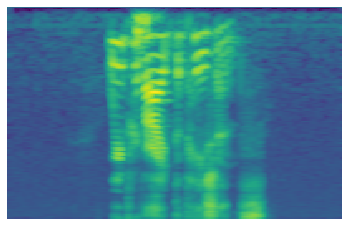

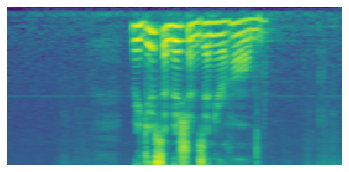

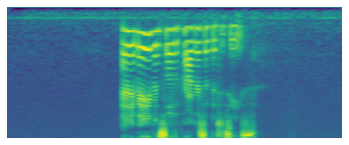

In [ ]:
sg_cfg = SpectrogramConfig(hop = 260)
cfg = AudioConfig(duration=1000, sg_cfg=sg_cfg)
pipe = Pipeline([oa, AudioToSpec(cfg)], as_item=True)
for i in range(3): 
    print(pipe(i).shape)
    pipe.show(pipe(i))

## Export

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 01b_script.ipynb.
Converted 01c_dataloader.ipynb.
Converted 02_data_transforms.ipynb.
Converted 03_data_pipeline.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_text_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Conve